## Neural Machine Translation using Tensorflow & Keras by implementing Base Transformer architecture on an Encoder-Decoder (seq2seq) model

## Employing Beam Search for effective Inference

### For this notebook, please ensure you have tensorflow library installed (my version==2.4.0). The languages to be translated in this tutorial are from English to French.

Note: Some knowledge on Attention Based Models and Object Oriented Programming employed in Deep Learning Models is assumed

My work on Attention Based Model is in this link -
https://github.com/garganm1/Neural-Machine-Translation-with-Bahdanau-Attention

In [1]:
## Importing some relevant libraries

from tensorflow.keras import Model, Input, Sequential

from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Layer, Add, GRU, \
                                    Activation, Softmax, Concatenate, TimeDistributed

from tensorflow.keras.losses import SparseCategoricalCrossentropy

import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow_text as text

import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import unicodedata
import re

### Section 1 - Data Processing

The dataset has been taken from - http://www.manythings.org/bilingual/

**Read the file 'fra.txt' that contains some English phrases/sentences and their translations in French**

In [2]:
df = pd.read_csv('fra.txt', sep='\t', header=None)

df.rename(columns={0:'eng', 1:'fra'}, inplace=True)

**Initialize functions that would process on the text**

In [3]:
# Note - Taken Directly from Tensorflow NMT Tutorial (with some modifications)

# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


# Process on the sentence/phrase
def preprocess_sentence(w):
    
    # Convert the text from unicode to ascii
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    # Removes any leading or trailing spaces
    w = w.strip()

    # Perhaps the most crucial point in processing -
    
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<BOS> ' + w + ' <EOS>'
    
    # BOS - Beginning of Sentence
    # EOS - End of Sentence
    
    # Return the processed text
    return w

In [4]:
# Applying the transformations to the text

df['fra_p'] = df['fra'].apply(lambda x: preprocess_sentence(x))
df['eng_p'] = df['eng'].apply(lambda x: preprocess_sentence(x))

df.drop([2], axis=1, inplace=True)

df.isnull().sum()

eng      0
fra      0
fra_p    0
eng_p    0
dtype: int64

In [5]:
# A view of how the dataframe looks like
df

,eng,fra,fra_p,eng_p
0,Go.,Va !,<BOS> va ! <EOS>,<BOS> go . <EOS>
1,Go.,Marche.,<BOS> marche . <EOS>,<BOS> go . <EOS>
2,Go.,Bouge !,<BOS> bouge ! <EOS>,<BOS> go . <EOS>
3,Hi.,Salut !,<BOS> salut ! <EOS>,<BOS> hi . <EOS>
4,Hi.,Salut.,<BOS> salut . <EOS>,<BOS> hi . <EOS>
...,...,...,...,...
185578,"Top-down economics never works, said Obama. ""T...","« L'économie en partant du haut vers le bas, ç...",<BOS> l economie en partant du haut vers le ba...,"<BOS> top down economics never works , said ob..."
185579,A carbon footprint is the amount of carbon dio...,Une empreinte carbone est la somme de pollutio...,<BOS> une empreinte carbone est la somme de po...,<BOS> a carbon footprint is the amount of carb...
185580,Death is something that we're often discourage...,La mort est une chose qu'on nous décourage sou...,<BOS> la mort est une chose qu on nous decoura...,<BOS> death is something that we re often disc...
185581,Since there are usually multiple websites on a...,Puisqu'il y a de multiples sites web sur chaqu...,<BOS> puisqu il y a de multiples sites web sur...,<BOS> since there are usually multiple website...


### Section 2 - Data Tokenization

**The processed text will be index-tokenized**

This means that for two texts such as -

1. I am here
2. He is here right now

the tokenized form would be -

1. [1, 2, 3, 0, 0]
2. [4, 5, 3, 6, 7]

Basically, the tokenized form would replace the word with a unique number that would represent that word.

- Notice the padding done at the end of sentence 1 (two 0's added). This will be done based on the maximum length of a sentence in a particular language

- Notice the repetiton of 3 in both tokenized forms which represent the word 'here' being repeated

There are other ways to tokenize such as using BERT Tokenizer that also takes sub-words into consideration apart from the whole words. For this notebook, we will stick with just the basic tokenization processes

In [6]:
# Function Initializing and Fitting on text
def create_tokenizer(lines):
    
    # Initialize tokenizer
    tokenizer = Tokenizer()
    
    # Fit the tokenizer on the text provided
    tokenizer.fit_on_texts(lines)
    
    # Return the tokenizer
    return tokenizer

# Creating tokenizer instances for English text
tokenizer_input = create_tokenizer(df['eng_p'])

# Creating tokenizer instances for French text
tokenizer_output = create_tokenizer(df['fra_p'])

In [7]:
# Function to compute maximum length of tokenized forms
def max_length(lines):
    
    # Compute the maximum length amongst all sentences in text
    return max([len(s.split()) for s in lines])

# Storing the maximum length for English
length_input = max_length(df['eng_p'])

# Storing the maximum length for French
length_output = max_length(df['fra_p'])

In [8]:
tokenizer_input.word_index

{'bos': 1,
 'eos': 2,
 'i': 3,
 'you': 4,
 'to': 5,
 'the': 6,
 'a': 7,
 't': 8,
 'is': 9,
 'tom': 10,
 'that': 11,
 'it': 12,
 's': 13,
 'he': 14,
 'do': 15,
 'of': 16,
 'this': 17,
 'in': 18,
 'me': 19,
 'have': 20,
 'don': 21,
 'we': 22,
 'was': 23,
 'what': 24,
 'my': 25,
 'for': 26,
 'can': 27,
 'are': 28,
 'm': 29,
 'your': 30,
 'be': 31,
 're': 32,
 'want': 33,
 'she': 34,
 'not': 35,
 'know': 36,
 'like': 37,
 'on': 38,
 'with': 39,
 'they': 40,
 'his': 41,
 'did': 42,
 'at': 43,
 'all': 44,
 'how': 45,
 'go': 46,
 'think': 47,
 'll': 48,
 'there': 49,
 've': 50,
 'him': 51,
 'and': 52,
 'time': 53,
 'here': 54,
 'about': 55,
 'very': 56,
 'get': 57,
 'didn': 58,
 'were': 59,
 'no': 60,
 'as': 61,
 'will': 62,
 'one': 63,
 'her': 64,
 'had': 65,
 'why': 66,
 'if': 67,
 'going': 68,
 'out': 69,
 'just': 70,
 'up': 71,
 'has': 72,
 'd': 73,
 'mary': 74,
 'who': 75,
 'would': 76,
 'need': 77,
 'so': 78,
 'good': 79,
 'let': 80,
 'tell': 81,
 'an': 82,
 'should': 83,
 'see': 84,
 '

In [9]:
# We will also need the number of unique tokenization there are in any text. 
# This just computes the number of unique words found in the text

# For English
vocab_size_input = len(tokenizer_input.word_index) + 1

# For French
vocab_size_output = len(tokenizer_output.word_index) + 1

In [10]:
# Function that will tokenize and pad the text
def encode_text(tokenizer, lines, length):
    
    # integer encode
    encoded = tokenizer.texts_to_sequences(lines)
    
    # pad encoded sequences
    padded = pad_sequences(encoded, maxlen=length, padding='post')

    return padded

# Apply the tokenization and padding on English Text
lang_input = encode_text(tokenizer_input, df['eng_p'], length_input)

# Apply the tokenization and padding on French Text
lang_output = encode_text(tokenizer_output, df['fra_p'], length_output)

In [11]:
# This will remove the tokenized EOS from the target language

lang_output_without_eos = np.empty(shape = (lang_output.shape[0], lang_output.shape[1]-1))

for i in range(len(lang_output)):
    try:
        # deleting "2" signifying 'EOS' token
        lang_output_without_eos[i] = np.delete(lang_output[i], np.where(lang_output[i] == 2))
    except:
        # if the tokenization and cleaning is done correctly, no output should come out of this loop
        print(lang_output[i], i)
        
# It is needed to provide as an input to the model (refraining from giving EOS signal to the model)

In [12]:
lang_output_without_eos

array([[1.000e+00, 1.110e+02, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.000e+00, 4.300e+02, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.000e+00, 2.158e+03, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [1.000e+00, 1.100e+01, 3.360e+02, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.000e+00, 6.845e+03, 1.000e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.000e+00, 5.700e+01, 1.720e+02, ..., 0.000e+00, 0.000e+00,
        0.000e+00]])

In [13]:
lang_output

array([[   1,  111,    2, ...,    0,    0,    0],
       [   1,  430,    2, ...,    0,    0,    0],
       [   1, 2158,    2, ...,    0,    0,    0],
       ...,
       [   1,   11,  336, ...,    0,    0,    0],
       [   1, 6845,   10, ...,    0,    0,    0],
       [   1,   57,  172, ...,    0,    0,    0]])

In [14]:
# Let's store our tokenized and processed text (model ready data) as a pickle file

import pickle

with open("./lang_eng_fra.pkl", 'wb') as f:
    pickle.dump(lang_input, f, protocol=4)

with open("./lang_fra_eng.pkl", 'wb') as f:
    pickle.dump(lang_output, f, protocol=4)

## Section 3 - Understanding the Transformer

Before we move onto the next section, it is imperative to understand the Transformer. Below are some links that can be referred as well -

1. https://arxiv.org/abs/1706.03762  (This is the original paper for Transformer)
2. http://jalammar.github.io/illustrated-transformer/  (This is a highly comprehensive explanation to Transformer)

The Transformer incorporates an Encoder-Decoder architecture but doesn't make use of RNN/LSTM and is comprised of Feed-Forward Network. This is the primary reason it is so fast and doesn't require so much computational power. The other reason it is so popular is that it has been more effective than previous SOTA models.

Now comes the heavy lifting. Let's look at the model from a high level and we will break it down into its smallest components from there on. Below snaps are taken from the article no. 2 mentioned above.

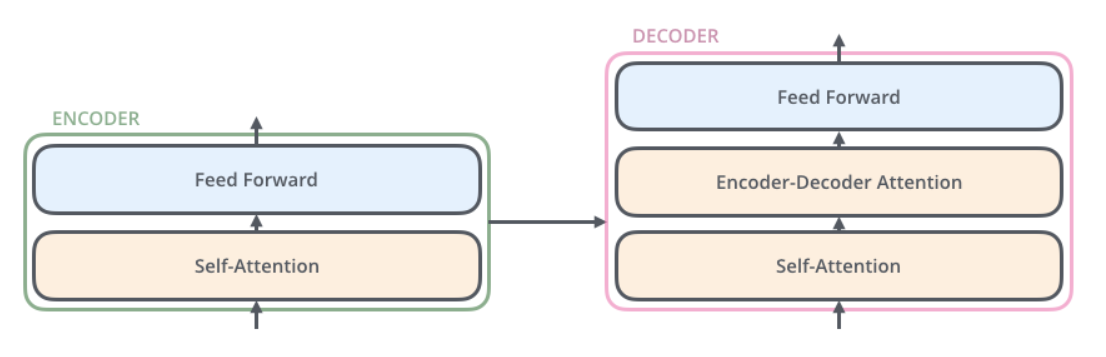

Both Encoder and Decoder Layers are comprised of a Self-Attention Layer and a Feed-Forward Network. The Decoder contains an extra Encoder-Decoder Attention that works the same way as the Self-Attention Layer. The Self-Attention Layer will be explained below.

The input to the Encoder would be the embedded version of source language and input to the Decoder would be the embedded version of target language. For instance, below pic shows the embedding created for each word

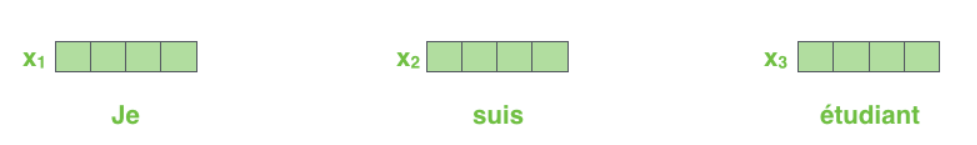

The Self-Attention Layer will create context by a special formula. This will be discussed in detail below.

The embedded words are converted to Queries, Keys and Values using the weight matrices W<sup>Q</sup>, W<sup>K</sup> and W<sup>V</sup> respectively. The weight matrices are the same for all embeddings (under one head) (think of head as just a single entity of below conversions)

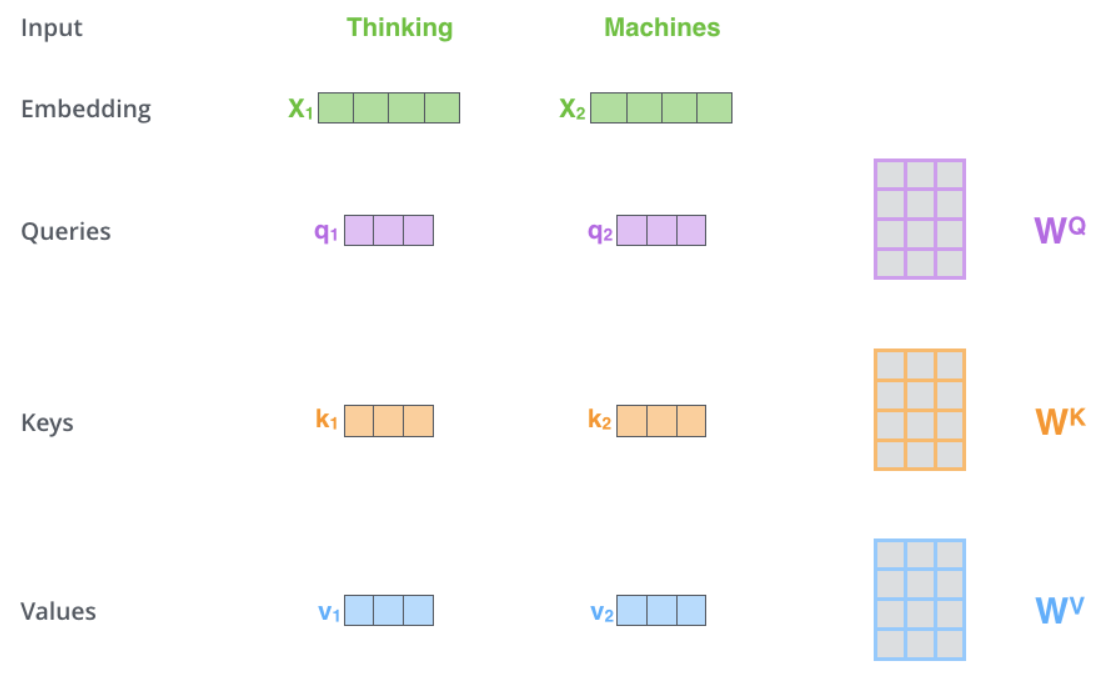

https://stats.stackexchange.com/questions/421935/what-exactly-are-keys-queries-and-values-in-attention-mechanisms

The above post provides an insight on what Query, Key and Value indicate. Think of Query as a representation of embedding that wants to ask how am I related to other embeddings. Key as the answer to that question and Value as a representation that incorporates this Query-Key pair with itself to provide another transformation to the embedding.

When these vectors are computed for each embedding, then the formula is applied that calculated the self-attention. It is broken down in the picture below-

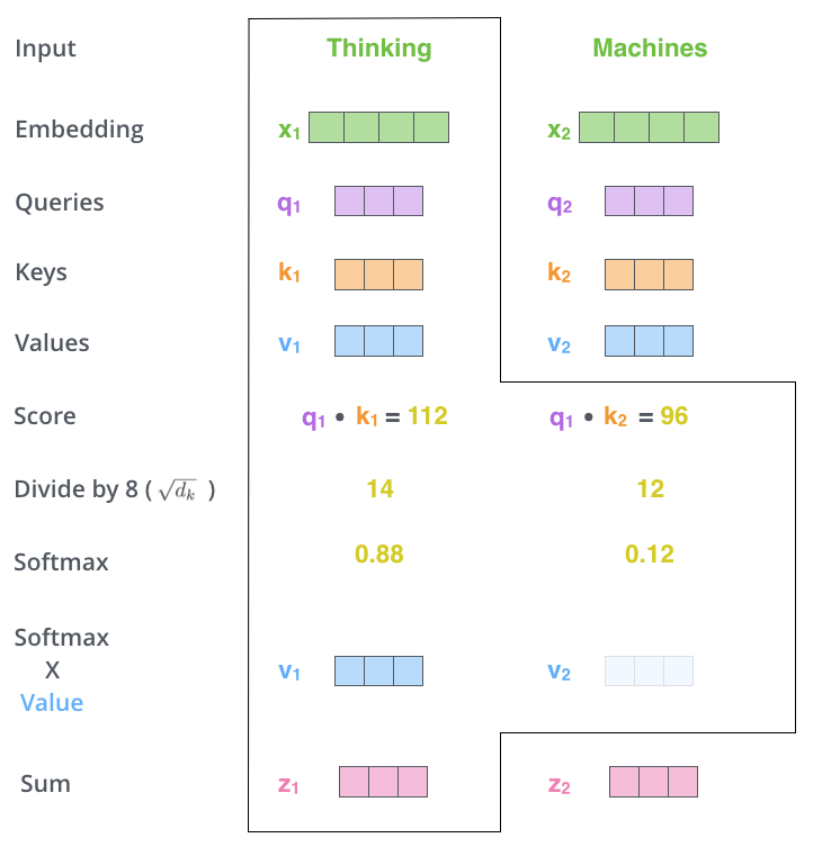

This computation is performed for all embeddings but let's look only at the first one and the same can be extrapolated for other embeddings.

1. The query and key vectors are multiplied to produce a score. Note how query of the embedding creates score for itself as well as other embeddings by taking keys of other embeddings
<br>

</br>

2. A normalization process takes place here by dividing the score with the square-root of the dimension size of the embedding (also called dimension of the model or d_model).
<br>

</br>

-- This normalization process is performed as softmax is applied after this operation and it is not desirable that the softmax get saturated (softmax is almost horizontal at extreme ends if you see its graph). The other reason of dividing it by square-root of the dimension size of the embedding is that when the query and key vectors are multiplied, the resulting variance increases by the dimension of embedding. To check this, the following code can be run independently:-

a = np.random.normal(size=(1000,50))  # mean 0, variance 0 <br> </br>
b = np.random.normal(size=(1000,50))  # mean 0, variance 0

c = np.sum(a*b, axis=1)

print(np.var(c))  # this will be almost equal to 50 (dimension size)

<br>

</br>

3. The third operation is a softmax operation that computes the context/attention weights of the current embedding with itself and other embeddings.
<br>

</br>

4. The softmax values of the embedding is multiplied with its Value vector. This tends to give emphasis to the embeddings that should be related to the current embedding and will reduce the emphasis on unrelated embeddings (since the low softmax score will be close to 0)
<br>

</br>

5. The above vectors obtained are summed up to get a final 'z' vector that contains attention information as well as the embedding information

The whole compuation is summarized in the snap below as a single formula:-

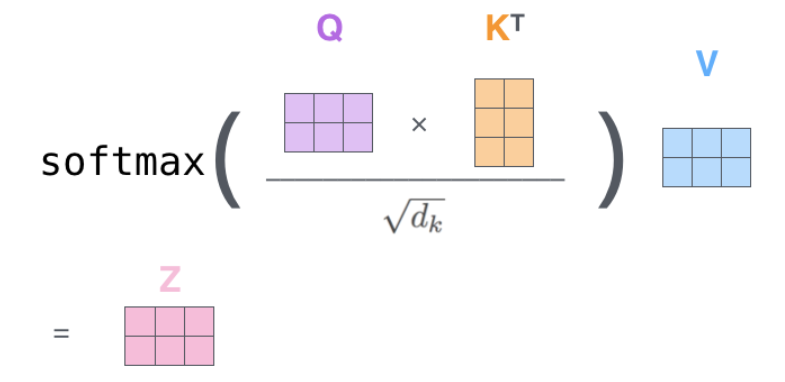

The z vectors are created for each embedding which are then passed to the FFN in the layer. In this way, the z vectors of each embedding would contain the information about the embedding and its relative context/attention with other embeddings.

A point to mention here is that the embeddings are provided to the model in vectorized format (and not in step-wise manner as in the case of RNN/LSTM). And so, there would be little information provided to the model about the position of the embedding/words since it would see the words as a bunch (grouped together) but without a sequence. To provide this information, a positional embedding is added with the original embedding that contains the information about the position of the word/emedding itself.

The authors of the original paper applied this using sine and cosine functions. This article - https://medium.com/@j.ali.hab/on-positional-encodings-in-the-attention-mechanism-ee81e6076b62 explains the encoding quite fairly and easily. The formula applied is given below:-

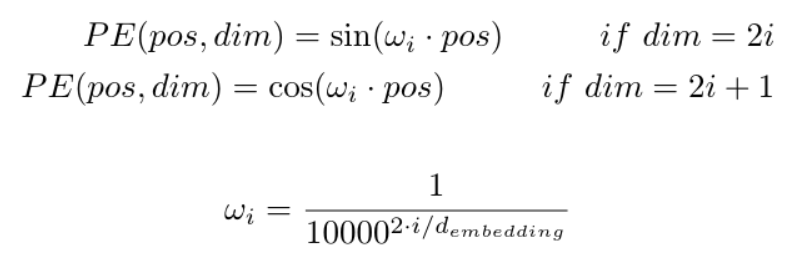

The whole idea of using this embedding formula is that it would create an increasing trend in both x and y direction of the embeddings matrix (giving the indication of a sequence in both directions. Look at the graph below to see how the values increase in both directions (pos = 2048, dim = 512).

The value 10,000 denotes the maximum length in any direction needed which can be reduced as per the data or kept as it is.

Firsty, the matrix (w<sub>i</sub>.pos) would be computed for i ranging from 0 to dim-1 and pos ranging from 0 to pos-1

Here, dim => embedding dimension, pos => number of words in the sequence

Then, for all even dimension in the matrix, the sine function is applied and for all odd dimensions, the cosine function is applied to get the positional encodings

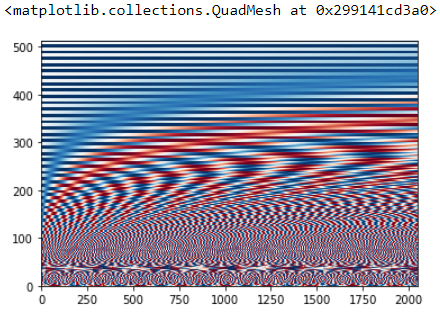

These positonal encodings are added with the original word embeddings so that the word embeddings carry the position of itself along with its representation.

The second major part of an Encoding layer is a FFN wherein the output from the previous Self-Attention Layer is passed on to the Dense layers.

After the Self-Attention and FFN layers, there is an additional Add & Normalize layer that acts as a skip connection. This ensures good gradient flow and maintaining/preserving/flowing of the original information. This Add & Normalize layer will take the output and the previous layer's input to combine and normalize them.

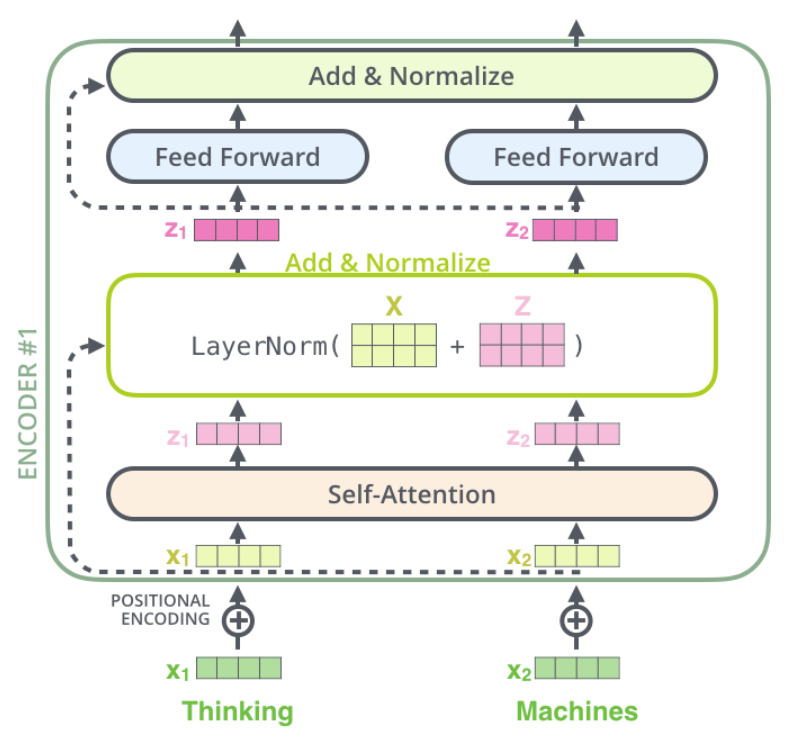

Once all of this is understood, think of the above operation acting on a single head on the encoding layer. This means we can do the above computations on multiple heads and get multiple 'z' representations of the embeddings. The authors of the paper used 8 heads in a single encoding layer.

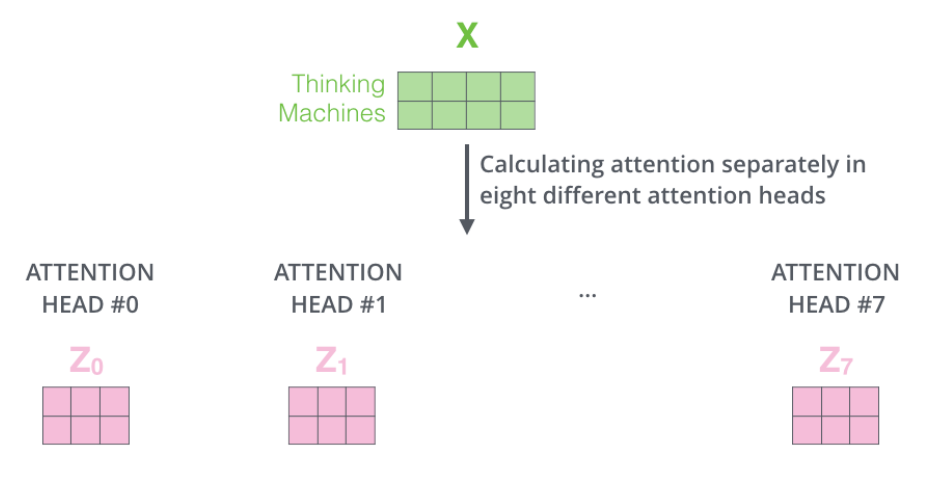

As we get multiple 'z' from each head, these have to be combined together to get single output for each embedding. The way this is done is by concatenating them together and passing them through a dense layer (with weight matrix W<sup>O</sup>)

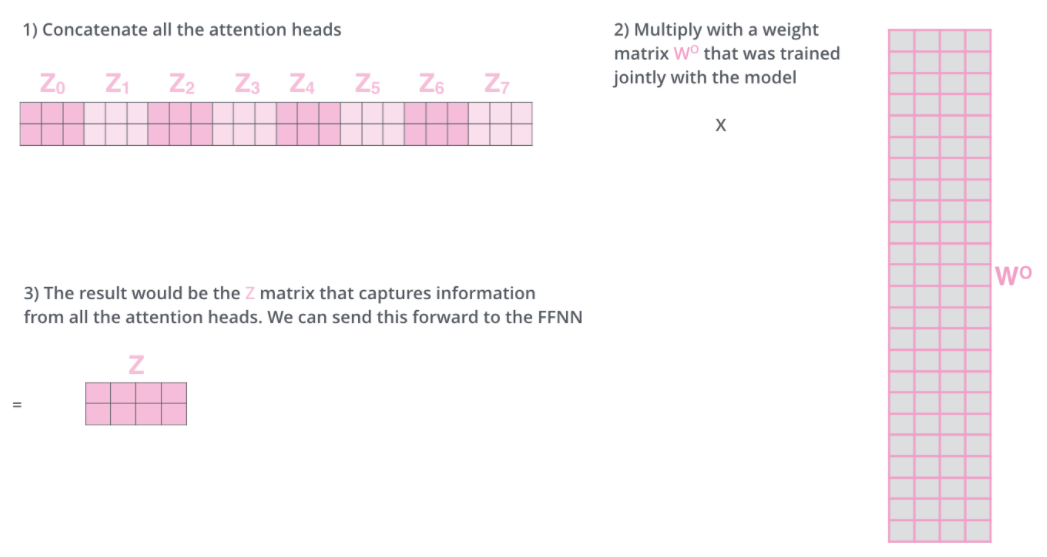

This is the complete work for a single encoding layer. Another thing to note is that there can be multiple encoding layers that would take the output of previous encoding layer as an input for their computations. If you see the image below, we have 2 encoding layers in this transformer architecture. The layers can be stacked one over other making this as one of the hyper-parameters to choose from. (A good initial choice generally is 6)

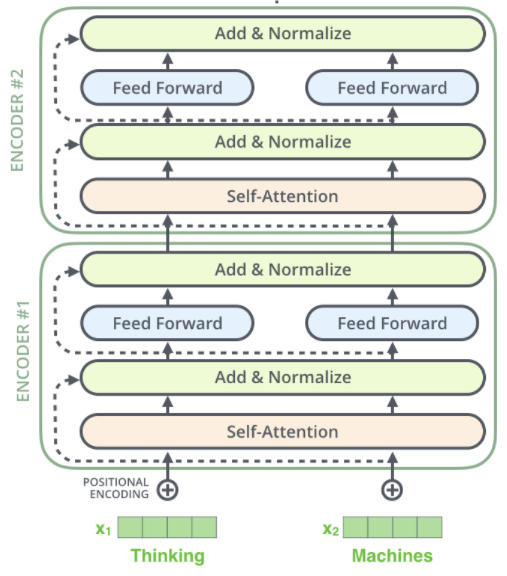

Now that the encoder has been discussed, let's look at how the decoder works in the transformer.

The decoder layer works quite similarly as the encoding layer. It taken the target language's words/embeddings as the input. Passes through a Self-Attention (and Add & Normalize layer) first. Then, another similar Self-Attention layer called the Encoder-Decoder Attention layer sandwiches in between. Finally, output from this is taken forward to the FFN layer. This completes a single decoding layer. Let's discuss what is different in the Encoder-Decoder Attention Layer

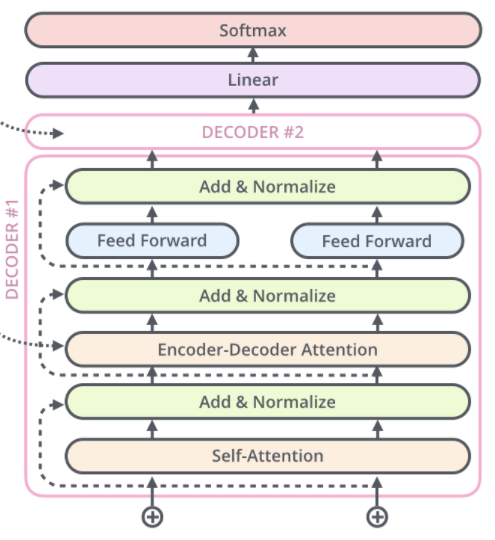

Inside the Encoder-Decoder Attention layer, the final output from the Encoder (which are the 'z' representations) are considered as the Key & Value vectors. Query vectors would the output from the previous Self-Attention layer inside the Decoder layer. This way, the transformer establishes a connection between the source and target embeddings. The 'query' target representations in combination with 'key' source representations give attention weights to the 'value' source representations. 

As stated earlier, think of Query as a representation of embedding that wants to ask how am I related to other embeddings. Key as the answer to that question and Value as a representation that incorporates this Query-Key pair with itself to provide another transformation to the embedding.

A single decoding layer can be stacked vertically to get multiple decoding layers. Inside each decoding layer, the Encoder-Decoder Attention layer would take additional input which is the final output from the Encoder ('z' representations).

The final output from the Decoder is passed on to a Linear Dense network and finally a Softmax operation is applied to get the normalized probability of each word in the target language's vocabulary. From a bigger picture, the transformer looks like this -

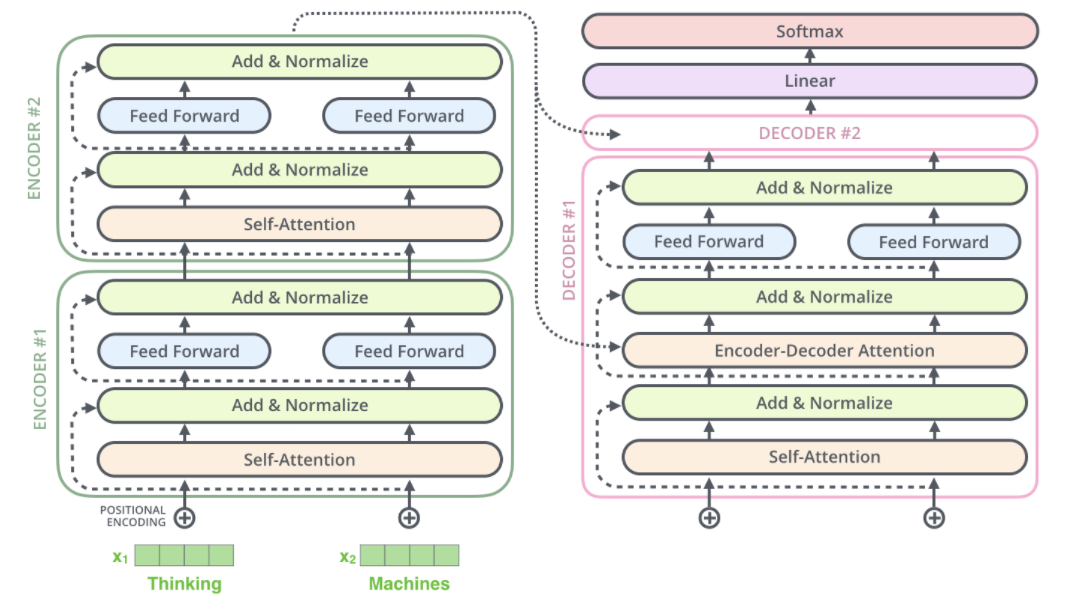

The Decoder outputs need to be in step-wise manner without actually moving through the sequences step-wise. What is meant by saying that the outputs need to be step-wise is that it would produce the next word by taking the previously generated words into account. But since the input to the Decoder is not in step-wise (i.e. the complete sequence is given to the decoder), a way should be found out to do just that. This is where the masks come into picture. Let's discuss about these below

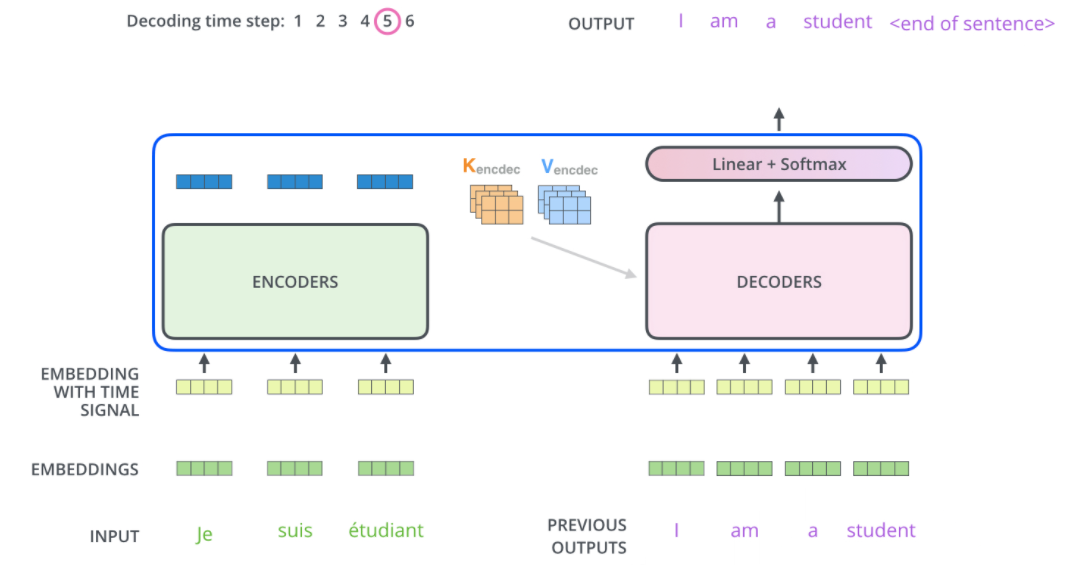

For the model to learn effectively, there is an additional masking computation applied to the embeddings. There are two types of masks provided - 

1. Padding Mask:- Since sequences have varying length, all empty positions of the sequences are masked. (See padding operation performed during tokenization). It is applied to both source and target embeddings.

2. Look-Ahead Mask:- This is the mask provided so that the Decoder isn't able to see the complete sequence. For instance, when the decoder has to output the first word, all embeddings except the first one are shown and the rest are masked. Moving sequentially, the decoder looks at the first two embeddings to output the next word. And so on....

The Look-Ahead Mask is quite important as it would enable the model to learn the sequences and would avoid data leakage. This also enables Teacher Forcing which means that the Decoder is fed with an additional word/embedding in a sequential manner. Note that this won't and can not be implemented during inference as the sequence isn't known beforehand. So, during inference, the previously generated/predicted sequence of words act as an input to the Decoder to predict the next word.

This completes the explanation of how the base Transformer work. Please go through the above, again and again if needed, making sure everything is understood before proceeding the next section. 

In the coming sections, the transformer would be formulated into code and then the processed data would be used to learn the model in translating from English to French.

### Section 4 - Transformer Model Peripherals

Let's start with formulation of positional encoding

#### Positional Encoding

In [15]:
def get_angles(pos, i, d_model):
    
    '''
    This function creates the w_i*pos values and returns them 
    given the pos and d_model to the function
    '''
    
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    
    return pos * angle_rates

In [16]:
def positional_encoding(position, d_model):
    
    '''
    This function gets the position and d_model values, 
    then creates the position encodings by calling the get_angles function.
    
    The values at even columns are mapped with the sine function and
    the values at odd columns are mapped with the cosine function
    
    An additional axis is applied finally to the encoding values 
    and returned as tf tensor with float32 type
    '''
    
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    # adding an axis at the start
    pos_encoding = angle_rads[np.newaxis, ...]

    # returning positional encodings
    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 2048, 512)


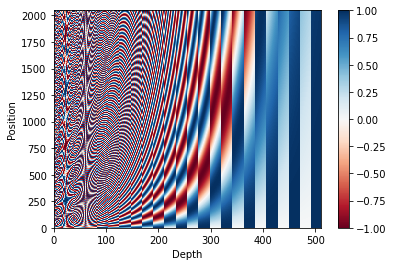

In [17]:
# Sample testing of the functions

n, d = 2048, 512
pos_encoding = positional_encoding(n, d)

print(pos_encoding.shape)

pos_encoding = pos_encoding[0]

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Position')
plt.xlabel('Depth')
plt.colorbar()
plt.show()

#### Padding and Look-Ahead Masking

In [18]:
def create_padding_mask(seq):
    
    '''
    This is a fairly simple function wherein a mask (1) value is provided against
    every token that is 0. For all other values of token, the mask value would be 0
    '''
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [19]:
# Testing out the padding masking function

x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [20]:
def create_look_ahead_mask(size):
    
    '''
    This function creates the look-ahead masks given the size of the sequence.
    
    A value 1 would indicate to mask the token at that position while
    a value 0 would indicate to keep the token visible
    '''
    
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [21]:
# Testing out the look-ahead masking function

x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

### Section 5 - Defining the Model

#### Scaled Dot Product Computation

In [22]:
def scaled_dot_product_attention(q, k, v, mask):
    
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead)
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """
    
    # Part 1
    # The query and key vectors being multiplied to produce a score
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    
    # Part 2
    # scale matmul_qk
    
    # the normalization process taking place here by dividing the score 
    # with the square-root of the dimension size of the embedding
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)  # scaled_attention_logits => (..., seq_len_q, seq_len_k)

    
    # add the mask to the scaled tensor
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
        # Addition of a huge negative number would mean that any attention point
        # which needs to be masked will give out close to 0 as an output in the 
        # softmax operation done after this.
        
        
    # Part 3
    # softmax is normalized on the last axis so that the scores add up to 1.
    # this computes the context/attention weights of the current embedding with itself and other embeddings
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    
    # Part 4
    # The softmax values of the embedding is multiplied with its Value vector. 
    # This tends to give emphasis to the embeddings that should be related to 
    # the current embedding and will reduce the emphasis on unrelated embeddings 
    # (since the low softmax score will be close to 0)
    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    # Finally the output and the attention_weights are returned
    return output, attention_weights

In [23]:
# Testing the scaled_dot_product_attention function

def print_out(q, k, v):
    
    # Computing the scaled_dot_product_attention
    temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
    
    # Printing the outputs
    print('Attention weights are:')
    print(temp_attn)
    print('Output is:')
    print(temp_out)

In [24]:
np.set_printoptions(suppress=True)

# Key
temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)  # (4, 3)

# Value
temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32)  # (4, 2)

In [25]:
# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [26]:
# This query aligns with a repeated key (third and fourth),
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [27]:
# This query aligns with a repeated key (third and fourth), second key and finally both first and second keys
# so that the associated values get averaged in the first and third query.

temp_q = tf.constant([[0, 0, 10],
                      [0, 10, 0],
                      [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


#### MultiHeadAttention Layer for Computing Attention Using Heads

In [28]:
class MultiHeadAttention(tf.keras.layers.Layer):
    
    # Initializing Layer's Instance's parameters
    
    def __init__(self, d_model, num_heads):
        
        super(MultiHeadAttention, self).__init__()
        
        self.num_heads = num_heads  # No of heads computing the Self-Attention
        self.d_model = d_model      # Dimensionality of the model (i.e. the Embedded Vector's Size)

        assert d_model % self.num_heads == 0
        
        # Computing depth at each head
        self.depth = d_model // self.num_heads
        
        # Initializing Dense layers for weights in Query, Key and Value vectors
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        # Initializing a Dense layer for weights in concatenated 'z' representations of all heads
        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    
    # Function being executed when the class's instance is called
    def call(self, v, k, q, mask):
        
        # Get the batch_size
        batch_size = tf.shape(q)[0]
        
        
        # Passing the query, key and value vectors through the dense layers
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)
        
        
        # Reshaping the vectors
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
        
        
        # Computing the scaled_dot_product_attention of the query, key and value vectors
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)      
        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        
        
        # Reshaping the scaled_attention
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        # scaled_attention.shape == (batch_size, seq_len_q, num_heads, depth)
        
        
        # Concatenating the 'z' representations
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        # concat_attention.shape == (batch_size, seq_len_q, d_model)
        
        
        # Passing the concatenated 'z' representations through a dense layer
        output = self.dense(concat_attention)
        # output.shape == (batch_size, seq_len_q, d_model)
        
        
        # returning the final output and the attention_weights
        return output, attention_weights

In [29]:
# Testing the MultiHeadAttention Layer

temp_mha = MultiHeadAttention(d_model=512, num_heads=8)

y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)

out, attn = temp_mha(y, k=y, q=y, mask=None)

out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

In [30]:
def point_wise_feed_forward_network(d_model, dff):
    
    '''
    Function for computation of last part of Encoder/Decoder layer
    i.e. the Feed-Forward Network that takes the input from the previous
    Attention Layer
    
    The first Dense layer has dff size with a relu activation.
    The second Dense layer has d_model size without any activation
    '''
    
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

In [31]:
# Testing the Feed-Forward Network Layer

sample_ffn = point_wise_feed_forward_network(512, 2048)

sample_ffn(tf.random.uniform((1, 50, 512))).shape  # bs, len, d_model

TensorShape([1, 50, 512])

Now, we can move onto defining the encoding and decoding layers

#### Encoder Layer

In [32]:
class EncoderLayer(tf.keras.layers.Layer):
    
    # Initializing Layer's Instance's parameters
    
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        
        super(EncoderLayer, self).__init__()
        
        # Initializing MultiHeadAttention Layer's Instance with specified d_model and num_heads
        self.mha = MultiHeadAttention(d_model, num_heads)
        
        # Initializing Feed-Forward Network Layer's Instance with specified d_model and dff
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        # Initializing instances for Layer Normalization (to be done after each MultiHeadAttention and Feed-Forward Network)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        # Dropout layers to implement some regularization
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

        
    # Function being executed when the class's instance is called  
    def call(self, x, training, mask):
        
        
        ## First part of encoder layer

        # Passing the sequence through the MultiHeadAttention Layer
        attn_output, _ = self.mha(x, x, x, mask)
        # attn_output.shape == (batch_size, input_seq_len, d_model)
        
        # Adding dropout with a training parameter that tells the model to drop only when the model is being trained
        attn_output = self.dropout1(attn_output, training=training)
        
        # Passing the output through a Add & Normalization layer
        out1 = self.layernorm1(x + attn_output)
        # out1.shape == (batch_size, input_seq_len, d_model)
        
        
        ## Second part of encoder layer

        # Passing the sequence through the Feed-Forward Network Layer
        ffn_output = self.ffn(out1)  
        # ffn_output.shape == (batch_size, input_seq_len, d_model)
        
        # Adding dropout with a training parameter that tells the model to drop only when the model is being trained
        ffn_output = self.dropout2(ffn_output, training=training)
        
        # Passing the output through a Add & Normalization layer
        out2 = self.layernorm2(out1 + ffn_output)  
        # out2.shape == (batch_size, input_seq_len, d_model)
        
        
        # returning the final output
        return out2

In [33]:
# Testing the Encoder Layer

sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 39, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 39, 512])

#### Decoder Layer

In [34]:
class DecoderLayer(tf.keras.layers.Layer):
    
    # Initializing Layer's Instance's parameters
    
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        
        super(DecoderLayer, self).__init__()
        
        # Initializing First MultiHeadAttention Layer's Instance with specified d_model and num_heads
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        
        # Initializing Second MultiHeadAttention Layer's Instance with specified d_model and num_heads
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        # Initializing Feed-Forward Network Layer's Instance with specified d_model and dff
        self.ffn = point_wise_feed_forward_network(d_model, dff)
    
        # Initializing instances for Layer Normalization (to be done after each MultiHeadAttention and Feed-Forward Network)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
        # Dropout layers to implement some regularization
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

        
    # Function being executed when the class's instance is called
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
                    # enc_output.shape == (batch_size, input_seq_len, d_model)

        ## First part of decoder layer
        
        # Passing the sequence through the First MultiHeadAttention Layer (Self-Attention)
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  
        # attn1.shape == (batch_size, target_seq_len, d_model)
        
        # Adding dropout with a training parameter that tells the model to drop only when the model is being trained
        attn1 = self.dropout1(attn1, training=training)
        
        # Passing the output through a Add & Normalization layer
        out1 = self.layernorm1(attn1 + x)

        
        ## Second part of decoder layer
        
        # Passing the sequence through the Second MultiHeadAttention Layer (Encoder-Decoder Attention)
        attn2, attn_weights_block2 = self.mha2(
                            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
                            # (value, key, query, mask)
            
        # Adding dropout with a training parameter that tells the model to drop only when the model is being trained
        attn2 = self.dropout2(attn2, training=training)
        
        # Passing the output through a Add & Normalization layer
        out2 = self.layernorm2(attn2 + out1)  
        # out2.shape == (batch_size, target_seq_len, d_model)
        
        
        ## Third part of decoder layer
        
        # Passing the sequence through the Feed-Forward Network Layer
        ffn_output = self.ffn(out2)  
        # ffn_output.shape == (batch_size, target_seq_len, d_model)
        
        # Adding dropout with a training parameter that tells the model to drop only when the model is being trained
        ffn_output = self.dropout3(ffn_output, training=training)
        
        # Passing the output through a Add & Normalization layer
        out3 = self.layernorm3(ffn_output + out2)  
        # out3.shape == (batch_size, target_seq_len, d_model)
        
        
        # returning the final output and attention weights after each MultiHeadAttention Layer
        return out3, attn_weights_block1, attn_weights_block2

In [35]:
# Testing the Decoder Layer

sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 28, 512)), sample_encoder_layer_output,
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 28, 512])

#### Complete Encoder

In [36]:
class Encoder(tf.keras.layers.Layer):
    
    # Initializing Layer's Instance's parameters
    
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
        
        super(Encoder, self).__init__()

        self.d_model = d_model         # Dimensionality of the model (i.e. the Embedded Vector's Size)
        self.num_layers = num_layers   # No of heads computing the Self-Attention
    
        # Initializing Embedding Layer that will convert the tokens to vectors of size d_model
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        
        # Initializing a variable that will hold the positional encodings
        self.pos_encoding = positional_encoding(maximum_position_encoding,
                                                self.d_model)
        
        # Initializing Encoder Layers in a list given the num_layers provided
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]
        
        # Initializing a Dropout Layer for regularization
        self.dropout = tf.keras.layers.Dropout(rate)
    
    
    # Function being executed when the class's instance is called
    def call(self, x, training, mask):
        
        # Calculating the length of sequence
        seq_len = tf.shape(x)[1]
        
        # Transforming the sequence to vector by passing it through the embedding layer
        x = self.embedding(x)  
        # x.shape == (batch_size, input_seq_len, d_model)
        
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        
        # adding position encoding to the embeddings
        x += self.pos_encoding[:, :seq_len, :]
        
        # Adding dropout with a training parameter that tells the model to drop only when the model is being trained
        x = self.dropout(x, training=training)

        # running the embedding through all encoding layers stacked on top of each other
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
            # x.shape == (batch_size, input_seq_len, d_model)
        
        # returning the final output of Encoder (x)
        return x

In [37]:
# Testing the Encoder

sample_encoder = Encoder(num_layers=4, d_model=512, num_heads=8,
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)

temp_input = tf.random.uniform((64, 29), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 29, 512)


#### Complete Decoder

In [38]:
class Decoder(tf.keras.layers.Layer):
    
    # Initializing Layer's Instance's parameters
    
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        
        super(Decoder, self).__init__()

        self.d_model = d_model         # Dimensionality of the model (i.e. the Embedded Vector's Size)
        self.num_layers = num_layers   # No of heads computing the Self-Attention
        
        # Initializing Embedding Layer that will convert the tokens to vectors of size d_model
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        
        # Initializing a variable that will hold the positional encodings
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        
        # Initializing Decoder Layers in a list given the num_layers provided
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]
        
        # Initializing a Dropout Layer for regularization
        self.dropout = tf.keras.layers.Dropout(rate)
    
    
    # Function being executed when the class's instance is called
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        
        # Calculating the length of sequence
        seq_len = tf.shape(x)[1]
        
        # for storing all layer's attention weights inside dictionary
        attention_weights = {}
        
        # Transforming the sequence to vector by passing it through the embedding layer
        x = self.embedding(x)  
        # x.shape == (batch_size, target_seq_len, d_model)
        
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        
        # adding position encoding to the embeddings
        x += self.pos_encoding[:, :seq_len, :]
        
        # Adding dropout with a training parameter that tells the model to drop only when the model is being trained
        x = self.dropout(x, training=training)
        
        # running the embedding through all decoding layers stacked on top of each other
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)
            # x.shape == (batch_size, target_seq_len, d_model)
            
            # Storing the weights inside the dictionary for each Decoding Layer
            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [39]:
# Testing the Decoder

sample_decoder = Decoder(num_layers=5, d_model=512, num_heads=8,
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)

temp_input = tf.random.uniform((64, 19), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 19, 512]), TensorShape([64, 8, 19, 29]))

#### Completing the Transformer by integrating the Encoder and Decoder

In [40]:
class Transformer(tf.keras.Model):
    
    # Initializing Layer's Instance's parameters
    
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input, pe_target, rate=0.1):
        
        super(Transformer, self).__init__()
        
        # Instantiating an Encoder Instance here
        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                                 input_vocab_size, pe_input, rate)
        
        # Instantiating a Decoder Instance here
        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                               target_vocab_size, pe_target, rate)
        
        # Initializing a Dense layer for passing final output of Decoder
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    
    # Function being executed when the class's instance is called
    def call(self, inp, tar, training, enc_padding_mask,
               look_ahead_mask, dec_padding_mask):
        
        # Passing the input and the mask through the Encoder
        enc_output = self.encoder(inp, training, enc_padding_mask)  
        # enc_output.shape == (batch_size, inp_seq_len, d_model)

        # Passing the target, enc_output and the masks (padding and look_ahead) through the Decoder
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        
        # Passing the dec_output through a dense layer
        final_output = self.final_layer(dec_output)  
        # dec_output.shape == (batch_size, tar_seq_len, target_vocab_size)
        
        # returning the final output and the attention weights from the Decoder
        return final_output, attention_weights

In [41]:
# Testing the Transformer

sample_transformer = Transformer(
    num_layers=3, d_model=512, num_heads=8, dff=2048,
    input_vocab_size=8500, target_vocab_size=8000,
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 30), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 39), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False,
                               enc_padding_mask=None,
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 39, 8000])

### Section 6 - Defining Model Parameters

In [42]:
# Preliminary Defining of Parameters

num_layers = 4            # Number of Encoding/Decoding layers 
d_model = 128             # Dimensionality of Model or Embedding Size
dff = 512                 # Dimensionality of Dense Layer insider each Encoding/Decoding Layer's FFN
num_heads = 8             # Number of Heads inside each Encoding/Decoding Layer
dropout_rate = 0.1        # Dropout Rate for regularization
batch_size = 32           # Batch Size for both Encoding and Decoding

The learning rate is varied (as per the paper). The formula is given below -

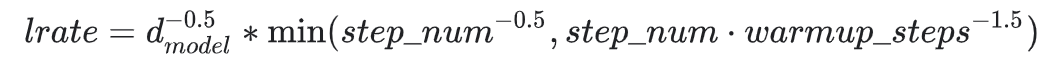

warmup_steps are 4000. The learning rate increases linearly up until the warmup and then decreases proportionally to the inverse square root of the step number

In [43]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
    def __init__(self, d_model, warmup_steps=4000):
        
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        
        # Computing the first part of minimum function here 
        # i.e. the sqrt of step and then inversing it ( = 1/sqrt(step))
        arg1 = tf.math.rsqrt(step)
        
        # Computing the second part of minimum function here
        arg2 = step * (self.warmup_steps ** -1.5)
        
        # returning the minimum of arg1 and arg2 multiplied with the inverse square root of d_model 
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [44]:
# Initializing the Learning Rate Instance
learning_rate = CustomSchedule(d_model)

# Initializing Adam Optimizer with same hyper-parameters as chosen in the paper
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Text(0.5, 0, 'Train Step')

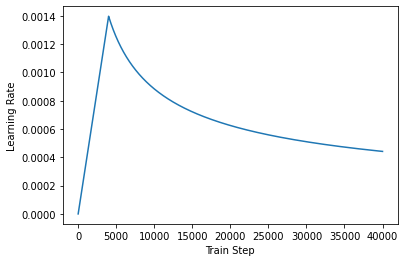

In [45]:
# Observing the learning rate as the training progresses

temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

The Model's loss needs to be defined. This is a simple Categorical Cross-Entropy i.e. comparing the predicted word (and the probabilities of words) with what the actual word is.

In [46]:
# An instance of the SparseCategoricalCrossentropy Loss 
# with some required arguments that define how it has to perform
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

# from_logits - unnormalized predictions passed (notice no softmax applied in the final layer of the decoder)
# reduction = 'none' - returns the full array of the per-sample losses in the batch

In [47]:
# Initializing Loss function here
def loss_function(real, pred):
    
    # mask shape = [batch_size, ...]
    mask = tf.math.logical_not(tf.math.equal(real, 0)) # tf.math.equal returns True when values are equal to 0
                                                #tf.math.logical_not inverses the above (True<==>False)
    
    # The mask is meant to only take losses where there is an actual word that exists i.e.
    # not for cases where the padding has been placed to put 0 as a token
    
    # Compute loss using real and pred values
    loss_ = loss_object(real, pred)
    # loss_ shape = [batch_size, ...]
    
    # casts mask variable as a tf loss type variable
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    # multiplies loss with mask (this operation will nullify any loss values where the padding has been put in place)
    loss_ *= mask
    # loss_ shape = [batch_size, ...]
    
            # computes the mean loss
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

An accuracy function can be defined to check how much accurately the model is predicting the words as compared to the actual ones

In [48]:
# Initializing Accuracy function here
def accuracy_function(real, pred):
    
    # Computes the accuracy by comparing if the index of the real (actual) word(s) is same as that of predicted
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))
    
    # Using a mask so that any word(s) that have been masked aren't considered for computing the accuracy
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    
    # The AND operation will only consider word(s) that aren't masked
    accuracies = tf.math.logical_and(mask, accuracies)
    
    # Changing the type of both variables
    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
        
            # computes the mean accuracy
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [49]:
# While this is optional and can be done in several other ways,
# here we instantiate variables to store the loss and accuracy for both training and testing(validation)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.Mean(name='test_accuracy')

In [50]:
# Creating the transformer object here

transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=vocab_size_input,
    target_vocab_size=vocab_size_output,
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

In [51]:
# Some other helper functions initialized below


# Function for shuffling the dataset for fitting the model with (implemented every epoch)
def shuffler(lang_inp, lang_out, lang_out_wo_eos):
    
    n_elem = lang_inp.shape[0]
    
    indices = np.random.choice(n_elem, size=n_elem, replace=False)

    return lang_inp[indices], lang_out[indices], lang_out_wo_eos[indices]


# Function for generating a batch of data from the dataset provided
def generator(batch_number, lang_input, lang_output, lang_output_without_eos):
    
    if len(lang_input) <= batch_number*batch_size+batch_size:
        
        return (lang_input[batch_number*batch_size:], 
            lang_output[batch_number*batch_size:],
            lang_output_without_eos[batch_number*batch_size:])
    
    return (lang_input[batch_number*batch_size: batch_number*batch_size+batch_size], 
            lang_output[batch_number*batch_size: batch_number*batch_size+batch_size],
            lang_output_without_eos[batch_number*batch_size: batch_number*batch_size+batch_size])

In [52]:
def create_masks(inp, tar):
    
    '''
    This function is entirely meant to create padding and look_ahead masks
    for both encoder and decoder
    '''
    
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])

    dec_target_padding_mask = create_padding_mask(tar)
    
    # gives maximum value at each element for all rows in look_ahead_masks compared against
    # the padding mask (since it has more rows than padding_mask)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    
    # returning padding mask for encoder, decoder and look_ahead mask for decoder
    return enc_padding_mask, combined_mask, dec_padding_mask

### Section 7 - Training the Model

In [53]:
EPOCHS = 20

In [54]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

# Decorator - Compiles the function below into a callable TensorFlow graph
@tf.function(input_signature=train_step_signature) 
def train_step(inp, tar, tar_inp): # runs for a single batch
    
    tar_inp = tar_inp      # This contains target sequences without EOS signal
    
    tar_real = tar[:, 1:]  # This contains target sequences without BOS signal

    # Here, the masks would be created for the batch of input and target sequences
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    
    # uses gradient tape so that differentiation takes place accordingly to update gradient and weights
    with tf.GradientTape() as tape:
        
        # Calling the transformer object to compute the predictions using the sequences and masks
        predictions, _ = transformer(inp, tar_inp,
                                     True,
                                     enc_padding_mask,
                                     combined_mask,
                                     dec_padding_mask)
        
        # Computes the Loss using the predictions and target sequence (not containing BOS signal)
        loss = loss_function(tar_real, predictions)
            
            
    # compute the gradients. (loss is differentiated against variables)
    gradients = tape.gradient(loss, transformer.trainable_variables)
    
    # Applies gradients to variables
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    
    # Store the loss of the batch (the object would compute the mean loss)
    train_loss(loss)
    
    # Compute the accuracy and store it in the object (the object would compute the mean accuracy)
    train_accuracy(accuracy_function(tar_real, predictions))
    
    # return the training loss
    return loss
    

    
# This function is used to compute the predictions on unseen data
def test_step(inp_test, tar_test, tar_inp_test):  # runs for a single batch
     
    # Compute the predictions by calling the function (defined below)
    predictions_test = evaluate_test(inp_test)
    
    tar_real_test = tar_test[:, 1:]  # This contains target sequences without BOS signal

    # Computes the Loss using the predictions and target sequence (not containing BOS signal)
    loss_test = loss_function(tar_real_test, predictions_test)
    
    # Store the loss of the batch (the object would compute the mean loss)
    test_loss(loss_test)
    
    # Compute the accuracy and store it in the object (the object would compute the mean accuracy)
    test_accuracy(accuracy_function(tar_real_test, predictions_test))
    
    # return the testing(validation) loss
    return loss_test

In [55]:
# Initializing function to evaluate the test batch
def evaluate_test(sentences, bs=batch_size, max_length=length_output-1):
    
    '''
    This function takes the source sequences, then uses the transformer
    to make predictions (without teacher forcing ofc) and then returns these prediction
    '''

    encoder_input = sentences

    # as the target is english, the first word to the transformer should be the
    # english start token.
    output = [tokenizer_output.word_index['bos'] for b in range(bs)]
    output = tf.cast(output, tf.float32)
    output = tf.convert_to_tensor([output])
    # output.shape == (1, batch_size)

    output = tf.transpose(output, perm=[1,0])
    # output.shape == (batch_size, 1)
    
    # Making predictions until the maximum length of the target is reached
    for i in range(max_length):
        
        # Here, the masks would be created for the batch of input and output sequences
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)
        
        # Calling the transformer object to compute the predictions using the sequences and masks
        predictions, attention_weights = transformer(encoder_input,
                                                     output,
                                                     False,
                                                     enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)
        
        
        # select the last word from the seq_len dimension
        predictions_last = predictions[:, -1:, :]  
        # predictions_last.shape == (batch_size, 1, vocab_size)
    
        # Get the index of the word/token which has the maximum probability
        predicted_id = tf.argmax(predictions_last, axis=-1)
        
        # Casting the value as float32
        predicted_id = tf.cast(predicted_id, tf.float32)

        # concatentate the predicted_id to the output which is then given to the decoder
        # as its input in the next iteration of the loop
        output = tf.concat([output, predicted_id], axis=-1)

    # return all predictions when the loop stops
    return predictions

In [56]:
# The training and validation test sets are created below

# To store loss of each epoch
loss_history = []

# Storing the number of batches for both training and validation
number_of_batches = 5000
number_of_batches_test = 25
    
# Splitting the dataset to form full batches of training set
lang_input_split = lang_input[:number_of_batches*batch_size]
lang_output_split = lang_output[:number_of_batches*batch_size]
lang_output_without_eos_split = lang_output_without_eos[:number_of_batches*batch_size]

# Splitting the dataset to form full batches of validation set
lang_input_test = lang_input[number_of_batches*batch_size:(number_of_batches+number_of_batches_test)*batch_size]
lang_output_test = lang_output[number_of_batches*batch_size:(number_of_batches+number_of_batches_test)*batch_size]
lang_output_without_eos_test = lang_output_without_eos[number_of_batches*batch_size:(number_of_batches+number_of_batches_test)*batch_size]

In [57]:
# This shows how many samples are used in training and validation
lang_input_split.shape, lang_input_test.shape

((160000, 53), (800, 53))

In [58]:
# The training will now be carried here

# To store loss of each epoch
loss_history_train = []
loss_history_test = []

# Setting the patience for cutting off the training (if validation loss is not reducing)
patience = 2
counter = 0

for epoch in range(EPOCHS):
    
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()
    
    # Shuffle the training dataset here
    lang_inp, lang_out, lang_out_wo_eos = shuffler(lang_input_split, lang_output_split, lang_output_without_eos_split)

    ### inp -> english, tar -> french
    
    # run for all batches of inputs and targets in training set
    for batch_number in range(number_of_batches):
        
        # Generate the batch to be sent to the model for training
        inp, targ, targ_inp = generator(batch_number, lang_inp, lang_out, lang_out_wo_eos)
        
        # call the train_step function to perform training
        loss_train = train_step(inp, targ, targ_inp)
        
        # Printing some mid-learning metrics to keep track
        if batch_number % 400 == 0:
            print(f'Epoch {epoch + 1} Batch {batch_number} Train Loss {train_loss.result():.4f} Train Accuracy {train_accuracy.result():.4f}')

    print("-----------------------------------------------")
    
    # run for all batches of inputs and targets in validation set
    for batch_number_test in range(number_of_batches_test):
        
        # Generate the batch to be sent to the model for testing
        inp_test, targ_test, targ_inp_test = generator(batch_number_test, lang_input_test, lang_output_test, lang_output_without_eos_test)

        # call the test_step function to perform testing
        loss_test = test_step(inp_test, targ_test, targ_inp_test)
    
        # Printing some mid-learning metrics to keep track
        if batch_number_test % 20 == 0:
            print(f'Epoch {epoch + 1} Batch {batch_number_test} Test Loss {test_loss.result():.4f} Test Accuracy {test_accuracy.result():.4f}')
    
    # Appending the total training and validation loss of the epoch here
    loss_history_train.append(loss_train)
    loss_history_test.append(loss_test)
    
    # Printing epoch summaries here
    print("-----------------------------------------------")
    print(f'Epoch {epoch + 1} | Train Loss {train_loss.result():.4f} | Train Accuracy {train_accuracy.result():.4f}')
    print(f'Epoch {epoch + 1} | Test Loss {test_loss.result():.4f} | Test Accuracy {test_accuracy.result():.4f}')

    print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')
    
            
    # The below set of checks are made to ensure that loss is reducing with each epoch. 
    # If it is not, we break out of the loop stopping the training
    if epoch >= 1:
        if loss_history_test[-1] >= loss_history_test[-2]:
            counter+=1
            if counter >= patience:
                print("breaking now as loss isn't reducing")
                break
        else:
            counter=0

Epoch 1 Batch 0 Train Loss 10.0777 Train Accuracy 0.0000
Epoch 1 Batch 400 Train Loss 8.5598 Train Accuracy 0.1228
Epoch 1 Batch 800 Train Loss 7.0734 Train Accuracy 0.1510
Epoch 1 Batch 1200 Train Loss 6.2805 Train Accuracy 0.1950
Epoch 1 Batch 1600 Train Loss 5.7723 Train Accuracy 0.2285
Epoch 1 Batch 2000 Train Loss 5.4128 Train Accuracy 0.2545
Epoch 1 Batch 2400 Train Loss 5.1318 Train Accuracy 0.2758
Epoch 1 Batch 2800 Train Loss 4.8963 Train Accuracy 0.2961
Epoch 1 Batch 3200 Train Loss 4.6959 Train Accuracy 0.3148
Epoch 1 Batch 3600 Train Loss 4.5166 Train Accuracy 0.3325
Epoch 1 Batch 4000 Train Loss 4.3596 Train Accuracy 0.3486
Epoch 1 Batch 4400 Train Loss 4.2185 Train Accuracy 0.3640
Epoch 1 Batch 4800 Train Loss 4.0885 Train Accuracy 0.3785
-----------------------------------------------
Epoch 1 Batch 0 Test Loss 5.6334 Test Accuracy 0.2870
Epoch 1 Batch 20 Test Loss 5.6917 Test Accuracy 0.2759
-----------------------------------------------
Epoch 1 | Train Loss 4.0273 | Tr

In [59]:
loss_history_test, loss_history_train

([<tf.Tensor: shape=(), dtype=float32, numpy=4.9991693>,
  <tf.Tensor: shape=(), dtype=float32, numpy=4.3083158>,
  <tf.Tensor: shape=(), dtype=float32, numpy=4.190775>,
  <tf.Tensor: shape=(), dtype=float32, numpy=4.142048>,
  <tf.Tensor: shape=(), dtype=float32, numpy=4.3999815>,
  <tf.Tensor: shape=(), dtype=float32, numpy=4.7472167>],
 [<tf.Tensor: shape=(), dtype=float32, numpy=2.5278552>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.6775602>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.4168693>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.8979833>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.7634845>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.6182283>])

**Let's store the model's weights**

In [60]:
transformer.save_weights('transformer_eng_fra_weights.h5')

In [61]:
transformer.load_weights('transformer_eng_fra_weights.h5')

### Section 8 - Model Inference

#### 1. Greedy Search

**Greedy Search is the most basic inference algorithm. It takes the word with the highest probability at each output from the decoder input. This word is then fed to the next time step of the decoder to predict the next word until we hit the 'end' signal**

In [62]:
# Function for processing the sentence first before its translation

def preprocessing_sentence(w):
    
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = 'bos ' + w + ' eos'
    return w

In [63]:
def evaluate(sentence, max_length=vocab_size_output):
    
    # processing the input sentence first  
    sentence = preprocessing_sentence(sentence)
    # tokenizing the input sentence
    sentence = [tokenizer_input.word_index[i] for i in sentence.split(' ')]
    # converting the sentence to a tf tensor
    encoder_input = tf.convert_to_tensor([sentence])

    # as the target is english, the first word to the transformer should be the
    # english start token.
    output = [tokenizer_output.word_index['bos']]
    output = tf.cast(output, tf.int32)
    output = tf.convert_to_tensor([output])
    
    # For Storing the Translated Text
    result = ''
    
    # Making predictions until the maximum length of the target is reached or the end token is hit
    for i in range(max_length):
        
        # Here, the masks would be created for the batch of input and output sequences
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

        # Calling the transformer object to compute the predictions using the sequences and masks
        predictions, attention_weights = transformer(encoder_input,
                                                     output,
                                                     False,
                                                     enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)
        
        # predictions.shape == (batch_size, seq_len, vocab_size)
        
        
        # select the last word from the seq_len dimension
        predictions = predictions[:, -1:, :]  
        # predictions.shape == (batch_size, 1, vocab_size)
        
        # Get the index of the word/token which has the maximum probability
        predicted_id = tf.argmax(predictions, axis=-1)
        
        # Casting the value as float32
        predicted_id = tf.cast(predicted_id, tf.int32)

        # concatentate the predicted_id to the output which is given to the decoder
        # as its input in the next iteration of the loop
        output = tf.concat([output, predicted_id], axis=-1)

        # break the loop if the predicted_id is equal to the end token (which is 2)
        if predicted_id == 2:
            break
        
        # if the loop continues, store the word in the result
        predicted_id = tf.cast(predicted_id, tf.int32)[0]
        result += tokenizer_output.index_word[np.array(predicted_id)[0]] + ' '
    
    # return the result and the attention_weights once the loop ends
    return result, attention_weights

In [64]:
def print_translation(sentence, tokens, ground_truth):
    
    # Function to print the input sentence, predicted (translated) sentence and the ground truth
    
    print(f'{"Input:":15s}: {sentence}')
    print(f'{"Prediction":15s}: {tokens}')
    print(f'{"Ground truth":15s}: {ground_truth}')

In [65]:
sentence = "this is coming good"
ground_truth = "ça vient bien"

translated_text, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : this is coming good
Prediction     : ca vient bien 
Ground truth   : ça vient bien


In [66]:
sentence = "You may speak"
ground_truth = "Vous pouvez parler"

translated_text, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : You may speak
Prediction     : vous pouvez parler 
Ground truth   : Vous pouvez parler


In [67]:
sentence = "it is very cold here"
ground_truth = "il fait vraiment froid ici"

translated_text, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : it is very cold here
Prediction     : il fait tres froid ici 
Ground truth   : il fait vraiment froid ici


#### 2. Beam Search

**Beam Search is slightly complicated. It produces K (which is user-defined) number of translations based on highest conditional probabilities of the words**

The algorithm is explained in one of my other projects (link - https://github.com/garganm1/Neural-Machine-Translation-with-Bahdanau-Attention). Please see to understand how the algorithm works.

In [68]:
# Function to get indices of k largest values in a 2-D matrix
def k_largest_index_argsort(a, k):
    idx = np.argsort(a.ravel())[:-k-1:-1]
    return np.column_stack(np.unravel_index(idx, a.shape))

In [69]:
# First function processing the Step-2 (that hits after Step-1)

def prelim_function_performing_beam_search(output, pred_topk_word_ids, pred_topk_log_probs, encoder_input, k):

    # Initialzing some empty lists
    
    # To store log probability for the the k*k combinations
    log_prob_for_beam = []
    
    # To store word_ids for each of the k*k combinations from the target language tokenizer
    word_ids_for_beam = []
    
    # For storing outputs for the next step for each k
    next_step_outputs = []
    
    # Run for k i.e. number of beam searches to produce
    for i in range(k):

        # Get the predicted token in the required format      
        predicted_id = tf.cast([[pred_topk_word_ids[i]]], tf.int32)

        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        cur_output = tf.concat([output, predicted_id], axis=-1)
        
        # The output for the next steps can be appended here
        next_step_outputs.append(cur_output)
        
        # Here, the masks would be created for the input and output sequence
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, cur_output)

        # Calling the transformer object to compute the predictions using the sequences and masks
        predictions, attention_weights = transformer(encoder_input,
                                                     cur_output,
                                                     False,
                                                     enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)
        
        # predictions.shape == (1, seq_len, vocab_size)
        
        
        # select the last word from the seq_len dimension
        predictions = predictions[:, -1:, :]  
        # predictions.shape == (1, 1, vocab_size)
        
        # Get the normalized predictions using Softmax
        cur_step_pred_normalized = tf.nn.softmax(predictions)[0]
        # pred_normalized shape = [1, tar_vocab_size]
        
        # Sort the predictions in descending order
        cur_step_pred_normalized_sorted = tf.sort(cur_step_pred_normalized, direction='DESCENDING').numpy()[0]
        # pred_normalized_sorted shape = [1, tar_vocab_size]

        # Converting normalized prediction to numpy data-type
        cur_step_pred_normalized = cur_step_pred_normalized.numpy()

        # Taking the top k predictions
        cur_step_pred_topk_probs = cur_step_pred_normalized_sorted[:k]
    
        # getting the word_ids of the tok k predictions based on their index positions
        cur_step_pred_topk_word_ids = np.array([np.argwhere(cur_step_pred_normalized[0]==x)
                                        for x in cur_step_pred_topk_probs])

        
        # Storing the word_ids here
        word_ids_for_beam.append(cur_step_pred_topk_word_ids)
        
        # Computing the negative log combined probability of previous word and current step's top k predictions
        current_step_topk_probs = pred_topk_log_probs[i] - np.log(cur_step_pred_normalized_sorted[:k])
        
        # Storing the negative log combined probability here
        log_prob_for_beam.append(current_step_topk_probs)
    
    # Converting the lists to arrays for working with numpy functions
    word_ids_for_beam = np.array(word_ids_for_beam)
    log_prob_for_beam = np.array(log_prob_for_beam)
    
    # Inverting the log_prob to inverse the relationship between them (lowest becomes highest and vice-versa)
    log_prob_for_beam_inv = 1/log_prob_for_beam
    
    # Getting the indices of the 2-d matrix: log_prob_for_beam_inv (for top k highest values)
    indices_where_prob_max = k_largest_index_argsort(log_prob_for_beam_inv, k=k)
    
    # Sort my index array based on second column
    indices_where_prob_max = indices_where_prob_max[np.argsort(indices_where_prob_max[:,1])]
    
    # Sort my index array based on first column
    indices_where_prob_max = indices_where_prob_max[np.argsort(indices_where_prob_max[:,0])]
    
    # The above sorting is a trick that will sort the first column values in ascending order and then the second column
    # so that one gets - [[0 2], [1 1]] and not [[1 1], [0 2]]
        
    # with the same logic, we store the word ids and their log probabilities to feed them to the next step

    cur_step_word_ids = word_ids_for_beam[indices_where_prob_max[:,0], indices_where_prob_max[:,1]]

    next_step_topk_log_probs = log_prob_for_beam[indices_where_prob_max[:,0], indices_where_prob_max[:,1]]
    
    # As we have new words now, we store them as sequences
    sequences = [[] for i in range(k)]
    
    for i, word_id in enumerate(pred_topk_word_ids):
        sequences[i].append(word_id)
    
    
    return sequences, cur_step_word_ids, next_step_outputs, next_step_topk_log_probs, k


In [70]:
# Second function processing all steps after Step-2

def function_performing_beam_search(cur_step_outputs, pred_topk_word_ids, pred_topk_log_probs, encoder_input, passing_sequences, k):

    # Initialzing some empty lists
    
    # To store log probability for the the k*k combination
    log_prob_for_beam = []
    
    # To store word_ids for each of the k*k combinations from the target language tokenizer
    word_ids_for_beam = []

    # For storing outputs for the next step for each k
    next_step_outputs = []
    
    # Run for k (here k might not be equal to the original k as some sequences might have ended)
    for i in range(k):
            
        # Get the predicted token in the required format 
        predicted_id = tf.cast(pred_topk_word_ids[i], tf.int32)
        predicted_id = tf.reshape(predicted_id, [1, 1])
        

        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        cur_output = tf.concat([cur_step_outputs[i], predicted_id], axis=-1)
        
        # The output for the next steps can be appended here
        next_step_outputs.append(cur_output)
        
        # Here, the masks would be created for the input and output sequence
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, cur_output)

        # Calling the transformer object to compute the predictions using the sequences and masks
        predictions, attention_weights = transformer(encoder_input,
                                                     cur_output,
                                                     False,
                                                     enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)
        
        # predictions.shape == (1, seq_len, vocab_size)
        
        
        # select the last word from the seq_len dimension
        predictions = predictions[:, -1:, :]  
        # predictions.shape == (1, 1, vocab_size)
        
        # Get the normalized predictions using Softmax
        cur_step_pred_normalized = tf.nn.softmax(predictions)[0]
        # pred_normalized shape = [1, tar_vocab_size]

        # Sort the predictions in descending order
        cur_step_pred_normalized_sorted = tf.sort(cur_step_pred_normalized, direction='DESCENDING').numpy()[0]
        # pred_normalized_sorted shape = [1, tar_vocab_size]

        # Converting normalized prediction to numpy data-type
        cur_step_pred_normalized = cur_step_pred_normalized.numpy()

        # Taking the top k predictions
        cur_step_pred_topk_probs = cur_step_pred_normalized_sorted[:k]

        # getting the word_ids of the tok k predictions based on their index positions
        cur_step_pred_topk_word_ids = np.array([np.argwhere(cur_step_pred_normalized[0]==x) 
                                        for x in cur_step_pred_topk_probs])
        
        # Storing the word_ids here
        word_ids_for_beam.append(cur_step_pred_topk_word_ids)
        
        # Computing the negative log combined probability of previous word and current step's top k predictions
        current_step_topk_probs = pred_topk_log_probs[i] - np.log(cur_step_pred_normalized_sorted[:k])
        
        # Storing the negative log combined probability here
        log_prob_for_beam.append(current_step_topk_probs)

    # Converting the lists to arrays for working with numpy functions
    
    word_ids_for_beam = np.array(word_ids_for_beam)    
    log_prob_for_beam = np.array(log_prob_for_beam)
    
    # Inverting the log_prob to inverse the relationship between them (lowest becomes highest and vice-versa)
    log_prob_for_beam_inv = 1/log_prob_for_beam
    
    # Getting the indices of the 2-d matrix: log_prob_for_beam_inv (for top k highest values)
    indices_where_prob_max = k_largest_index_argsort(log_prob_for_beam_inv, k=k)
    
    # Sort my index array based on second column
    indices_where_prob_max = indices_where_prob_max[np.argsort(indices_where_prob_max[:,1])]
    
    # Sort my index array based on first column
    indices_where_prob_max = indices_where_prob_max[np.argsort(indices_where_prob_max[:,0])]


    # with the same logic, we store the word ids and their log probabilities to feed them to the next step
    
    next_step_word_ids = word_ids_for_beam[indices_where_prob_max[:,0], indices_where_prob_max[:,1]]

    next_step_topk_log_probs = log_prob_for_beam[indices_where_prob_max[:,0], indices_where_prob_max[:,1]]


    # Now, we append the word_ids to the sequences we have to progress
    for i, word_id in enumerate(next_step_word_ids):
        passing_sequences[i].append(word_id[0][0])


    return passing_sequences, next_step_word_ids, next_step_outputs, next_step_topk_log_probs, k


In [71]:
# Helper function to convert the sequence of word-ids to words using the target language's tokenizer
def indices_to_sentences(indices):
    
    all_sentences = []
    
    for single_seq in indices:
        result = ''
        
        for i in single_seq[0][:-1]:
            result += tokenizer_output.index_word[i] + ' '
            
        all_sentences.append(result)
            
    return all_sentences

In [72]:
def evaluate_with_beam(sentence, k, max_length=vocab_size_output):
    
    # processing the input sentence first     
    sentence = preprocessing_sentence(sentence)
    # tokenizing the input sentence
    sentence = [tokenizer_input.word_index[i] for i in sentence.split(' ')]
    # converting the sentence to a tf tensor
    encoder_input = tf.convert_to_tensor([sentence])
    
    # Initialize lists to store all final sequences and their negative log probabilities
    final_sequences = [[] for i in range(k)]
    final_log_probs = [[] for i in range(k)]

    # as the target is english, the first word to the transformer should be the
    # english start token.
    output = [tokenizer_output.word_index['bos']]
    output = tf.cast(output, tf.int32)
    output = tf.convert_to_tensor([output])

    
    ## Step-1 begins here
    
    
    # Here, the masks would be created for the input and output sequence
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)
    
    # Calling the transformer object to compute the predictions using the sequences and masks
    predictions, attention_weights = transformer(encoder_input,
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # predictions.shape == (1, seq_len, vocab_size)

    # select the last word from the seq_len dimension
    predictions_last = predictions[:, -1:, :][0]  
    # predictions_last.shape == (1, 1, vocab_size)
    
    # Get the normalized predictions using Softmax
    pred_normalized = tf.nn.softmax(predictions_last)
    # pred_normalized shape = [1, tar_vocab_size]

    # Sort the predictions in descending order
    pred_normalized_sorted = tf.sort(pred_normalized, direction='DESCENDING').numpy()[0]
    # pred_normalized_sorted shape = [1, tar_vocab_size]
    
    # Converting normalized prediction to numpy data-type
    pred_normalized = pred_normalized.numpy()
    
    # Taking the top k predictions
    pred_topk_probs = pred_normalized_sorted[:k]

    # getting the word_ids of the tok k predictions based on their index positions
    pred_topk_word_ids = [np.argwhere(pred_normalized==x)[0][1] for x in pred_topk_probs]

    # Computing negative log probabilities of the first k predictions
    pred_topk_log_probs = -np.log(pred_normalized_sorted[:k])
    

    ## Step-2 begins here
    
    
    # Running the preliminary function after step-1
    sequences, next_step_word_ids, next_step_outputs, next_step_topk_log_probs, k = prelim_function_performing_beam_search(
                                                                    output,
                                                                    pred_topk_word_ids, 
                                                                    pred_topk_log_probs, 
                                                                    encoder_input, 
                                                                    k=k)
    
    # Here, we check if we hit 'end' signal in any sequence and cut-off those branches for further inference
    
    end_outputs = []
    indices_to_cut = []
    
    for i, word_id in enumerate(next_step_word_ids):

        if word_id == 2:
            end_outputs.append(word_id)
            # Store the indices that we need to cut off
            indices_to_cut.append(i)
            
    # Creating a copy of existing sequences
    passing_sequences = sequences.copy()
    
    # Counter to point index of list to store
    finished_sequences_counter = 0
            
    # If 'end' is hit in one or more sequences
    if len(end_outputs) != 0:
        
        # For each indices that need to be cut
        for i in indices_to_cut:
            
            # First create a copy of passing sequences
            passing_seq_copy = passing_sequences.copy()
            
            # Append the final sequence and its negative log probability
            final_sequences[finished_sequences_counter].append(passing_seq_copy.pop(i))
            final_log_probs[finished_sequences_counter].append(next_step_topk_log_probs[i])
            
            # increase the counter by 1 to store another sequence at the next location
            finished_sequences_counter += 1
            
        # The sequences that end have to be removed from passing sequences to the next step
        for ele in sorted(indices_to_cut, reverse = True):  
            del passing_sequences[ele] 

        
        # Reduce the number of k by the number of sequences that have ended
        k = k - len(end_outputs)
        
        # The word_ids for the next step also are stripped off of the ended sequence(s)
        next_step_word_ids = np.delete(next_step_word_ids, indices_to_cut)
        
        # The negative log probs for the next step also are stripped off of the ended sequence(s)
        next_step_topk_log_probs = np.delete(next_step_topk_log_probs, indices_to_cut)
        
        
        
    ## All steps after Step-2 begin here
    
    
    # Run this loop until all sequences are found
    while k > 0:
        
        # Running the function after Step-2
        passing_sequences, next_step_word_ids, next_step_outputs, next_step_topk_log_probs, k = function_performing_beam_search(
                                                                    next_step_outputs,
                                                                    next_step_word_ids,
                                                                    next_step_topk_log_probs, 
                                                                    encoder_input, 
                                                                    passing_sequences, 
                                                                    k=k)
        
        
        # Here, we check if we hit 'end' signal in any sequence and cut-off those branches for further inference
    
        end_outputs = []
        indices_to_cut = []

        for i, word_id in enumerate(next_step_word_ids):
            
            if word_id == 2:
                end_outputs.append(word_id)
                indices_to_cut.append(i)

        # If 'end' is hit in one or more sequences
        if len(end_outputs) != 0:
            
            # For each indices that need to be cut
            for i in indices_to_cut:
                
                # First create a copy of passing sequences
                passing_seq_copy = passing_sequences.copy()
                
                # Append the final sequence and its negative log probability
                final_sequences[finished_sequences_counter].append(passing_seq_copy.pop(i))
                final_log_probs[finished_sequences_counter].append(next_step_topk_log_probs[i])

                # increase the counter by 1 to store another sequence at the next location
                finished_sequences_counter += 1
            
            # Reduce the number of k by the number of sequences that have ended
            k = k - len(end_outputs)
            
            # The sequences that end have to be removed from passing sequences to the next step           
            for ele in sorted(indices_to_cut, reverse = True):  
                del passing_sequences[ele] 
            
            # The word_ids for the next step also are stripped off of the ended sequence(s)
            next_step_word_ids = np.delete(next_step_word_ids, indices_to_cut)
            
            # The negative log probs for the next step also are stripped off of the ended sequence(s)
            next_step_topk_log_probs = np.delete(next_step_topk_log_probs, indices_to_cut)
            
            
    
    # Once out of the loop, all sequences have been found. 
    # Now, let's get the word from each word id to create sentences
    final_sentences = indices_to_sentences(final_sequences)
    
        
    # Print the sentences and their negative log probabilites (the lower the more probable)
    for i, sentence in enumerate(final_sentences):
        print("Translated Sentence {} : {}".format(i+1, sentence))
        print("Associated Neg Log Probability: {} \n".format(final_log_probs[i]))


In [73]:
evaluate_with_beam('it is very cold here', 5)

Translated Sentence 1 : ce tres froid 
Associated Neg Log Probability: [4.7579575] 

Translated Sentence 2 : il tres froid ici 
Associated Neg Log Probability: [0.33498693] 

Translated Sentence 3 : c tres rhume la 
Associated Neg Log Probability: [4.0017323] 

Translated Sentence 4 : on tres froid ici 
Associated Neg Log Probability: [4.830948] 

Translated Sentence 5 : ca a froid ici 
Associated Neg Log Probability: [3.0651] 



In [74]:
evaluate_with_beam('You may speak', 5)

Translated Sentence 1 : vous parler 
Associated Neg Log Probability: [1.0982362] 

Translated Sentence 2 : il parler 
Associated Neg Log Probability: [1.2011795] 

Translated Sentence 3 : tu vous parler 
Associated Neg Log Probability: [2.6814516] 

Translated Sentence 4 : ca peut parler 
Associated Neg Log Probability: [3.2999525] 

Translated Sentence 5 : on vous peut parler 
Associated Neg Log Probability: [4.1590004] 



In [75]:
evaluate_with_beam('this is very good', 5)

Translated Sentence 1 : c tres bon 
Associated Neg Log Probability: [0.6709021] 

Translated Sentence 2 : il fort bien 
Associated Neg Log Probability: [2.0666888] 

Translated Sentence 3 : ca vraiment beau 
Associated Neg Log Probability: [2.3271205] 

Translated Sentence 4 : ce agit bonne 
Associated Neg Log Probability: [4.0318303] 

Translated Sentence 5 : voila tres bien 
Associated Neg Log Probability: [2.9427016] 



This concludes the implementation of Transformer architecture on the application of language translation. Transformers are a revolutionary 'technology' especially in the field of NLP. Recently, some progress has been made on its application in Computer Vision problems as well such as - https://arxiv.org/pdf/2010.11929.pdf. Nevertheless, they have been a great step in improving and elongating the research depth in Deep Learning.